# How does salary vary with demographics?

Great! So, now we have a distribution of the salaries converted to US Dollars, but there's a problem. If you made \$100,000 per year at a data science job in the US, that would be pretty normal. But what if you made \$100,000 in a country with a cheaper cost of living? Then, you would essentially be making much more money!

We need to convert these salaries into values that represents the respondent's relative "Purchasing Power", or "PPP". I have found an index from the World Bank website (https://data.worldbank.org/indicator/PA.NUS.PPP), which contains a "Purchasing Power Parity" conversion factor. Directly from their website: "Purchasing power parity conversion factor is the number of units of a country's currency required to buy the same amounts of goods and services in the domestic market as U.S. dollar would buy in the United States."

Put simply, it describes how much the same item costs in different countries. This new conversion factor will take into account both the exchange rate and the cost of living in each country. Let's try it out!

Edit: This took a ton more work than I was anticipating. I realized that the countries in mc_df and the ppp_df had slightly different values. As a result, we were only able to see ~400 of the 16000 salaries converted to purchasing power. Instead of manually correcting them one by one, or writing a complicated algorithm to fix it, I decided to pull in a few more data sets. I will explain my methodology here.

I reasoned that if I could connect the country codes in ppp_df to the currency codes in mc_df, then we would be able to assign each respondent a ppp value. I could not find an up to date table that linked currency codes to country codes. However, I was able to find two new tables from the same website. One table has country codes in the same row as country names, while the other has currency codes in the same row as country names. I figured that since they are from the same website, they would use the same country names, and that would allow me to link ppp_df to mc_df. I added three columns to ppp_df: country names, currency codes, and country codes. It produced much better results than when I tried to match ppp_df to mc_df's data, and increased the amount of usable data by %.

In [111]:
ppp_df = pd.read_csv('ppp.csv', header=2)
ppp_df.drop(["{:02d}".format(x) for x in range(1960,2016)], axis=1, inplace=True)
ppp_df = ppp_df.drop(['Indicator Name', 'Indicator Code', '2017', 'Unnamed: 62'], axis=1)
ppp_df.head()

,Country Name,Country Code,2016
0,Aruba,ABW,NaN
1,Afghanistan,AFG,20.284962
2,Angola,AGO,83.700724
3,Albania,ALB,43.156965
4,Andorra,AND,NaN


In [112]:
# Dataframe was pulled in as a list of dfs, however, we only needed one, so I appended [2] to select just that one
country_codes_df = pd.read_html('http://www.nationsonline.org/oneworld/countries-classification.htm')[2]
# Drop some empty/irrelevant columns
country_codes_df.drop([0, 1, 4, 5, 6], axis=1, inplace=True)
# The column names were imported into the first row, so we will rename the columns
country_codes_df.columns = country_codes_df.iloc[0,:]
# Some of the countries had an asterik, we can use a for loop to replace '*' with an empty space '' 
for i, country in enumerate(country_codes_df['Country']):
    country_codes_df.loc[i, 'Country'] = country.replace('*', '')
# Preview the dataframe
print('COUNTRY CODES')
country_codes_df.head()

COUNTRY CODES


,Country,Ctry Code
0,Country,Ctry Code
1,Afghanistan,AFG
2,Albania,ALB
3,Algeria,DZA
4,Andorra,AND


In [113]:
# This one was a little trickier. The data was split into multiple tables, so we slice into the dfs with [2:7]
currency_codes_df = pd.read_html('http://www.nationsonline.org/oneworld/currencies.htm')[2:7]
# This leaves us with a list of dataframes. Luckily, we can iterate through it easily with a for loop
for each in currency_codes_df:
    each.drop([0, 4, 5], axis=1, inplace=True)
    each.columns = each.iloc[0]
# After each dataframe gets a little processed, we can concatenate them together into one datafame.
currency_codes_df = pd.concat(currency_codes_df)
currency_codes_df['Code A'].fillna('NONE', inplace=True)
currency_codes_df.head()

,Country,Currency Name,Code A
0,Country,Currency Name,Code A
1,1 Japanese Yen 2 Ethiopian Birr 1. U.S. Dolla...,NaN,NONE
2,Afghanistan,Afghani,AFN
3,Albania,Lek,ALL
4,Algeria,Algerian Dinar,DZD


    Next, we will combine the currency_codes_df, country_codes_df, and ppp_df

In [122]:
# I will make a new column using the common country name between my two intermediate datasets
ppp_df['New Country Column'] = ppp_df['Country Code']
for i, country in enumerate(ppp_df['Country Code']):
    try:
        ppp_df.loc[i, 'New Country Column'] = country_codes_df[country_codes_df['Ctry Code'] == country]['Country'].tolist()[0]
    except:
        pass

    
# Once again, we will loop through and use the country name to match with currency codes. These 
# currency codes will the be used to match a country's PPP to the correct row in mc_df
ppp_df['Currency Codes'] = ppp_df['New Country Column']
for i, country in enumerate(ppp_df['New Country Column']):
    try:
        ppp_df.loc[i, 'Currency Codes'] = currency_codes_df[currency_codes_df['Country'] == country]['Code A'].tolist()[0]
    except:
        pass
ppp_df.set_index('Currency Codes', inplace=True)
ppp_df.head()

,Country Name,Country Code,2016,New Country Column
Currency Codes,,,,
ABW,Aruba,ABW,NaN,ABW
AFG,Afghanistan,AFG,20.284962,AFG
AGO,Angola,AGO,83.700724,AGO
ALB,Albania,ALB,43.156965,ALB
AND,Andorra,AND,NaN,AND


In [156]:
ppp_df['2016'].loc['USD'] * float(mc_df.loc[3, 'CompensationAmount'].replace(',', ''))

Currency Codes
USD   NaN
USD   NaN
USD   NaN
Name: 2016, dtype: float64

In [154]:
# I will convert each salary into its PPP value using a similar method to our USD conversion, above.
# Initialize the array
ppp_array = np.zeros(len(mc_df)).reshape(len(mc_df), 1)

# Iterate through each currency in our mc_df, and multiply the salary for each row with the correct PPP value.
export = None
for i, currency in enumerate(mc_df['CompensationCurrency']):
    if type(mc_df.loc[i, 'CompensationAmount']) == str:
        try:
#             print(mc_df.loc[i, 'CompensationAmount'], 'thing1')
#             print(ppp_df['2016'].loc[currency], 'thing2')
            print(currency)
#             print('i', i, 'thing3')
            export = currency
            ppp_array[i] = float(mc_df.loc[i, 'CompensationAmount'].replace(',', '')) * (ppp_df['2016'].loc[currency])
        except:
            ppp_array[i] = np.nan

mc_df['PurchasingPower'] = ppp_array

# Again, we must remove the outliers. Otherise, they will cause headaches
# First, let's calculate the IQR. We'll use the quantile() method to get our quartiles
first_quartile = mc_df['PurchasingPower'].quantile(0.25)
third_quartile = mc_df['PurchasingPower'].quantile(0.75)
iqr = third_quartile - first_quartile

# This conditional filter is a bit hard to read so I'll explain
# It uses the bitwise operator for 'and', which is '|', to separate it's two conditional statements.
# These conditional statements limit the range of the data within IQR +/- 1.5 * IQR.
# Finally, the ['ConvertedSalaries'] slice is added to 
# the end to select only one column for the new column ['FilteredSalaries']
mc_df['FilteredPurchPower'] = mc_df[((first_quartile - 1.5*iqr) >= mc_df['PurchasingPower']) |
                          (mc_df['PurchasingPower'] <= (third_quartile + 1.5*iqr))]['PurchasingPower']
ppp_df['2016'].loc[export]

USD
AUD
RUB
INR
TWD
nan
USD
USD
CZK
RUB
nan
COP
EUR
PLN
GBP
USD
USD
EUR
nan
MXN
USD
nan
INR
EUR
nan
EUR
USD
HKD
EUR
USD
USD
HUF
USD
USD
USD
nan
EUR
BRL
BRL
HUF
nan
USD
BRL
RUB
GBP
nan
GBP
USD
EUR
USD
PLN
USD
USD
EUR
USD
INR
PLN
USD
nan
USD
USD
nan
USD
USD
NZD
EUR
EUR
CLP
EUR
nan
nan
USD
USD
USD
nan
USD
CZK
USD
nan
PLN
EUR
CZK
USD
nan
USD
nan
GBP
nan
nan
RUB
USD
ZAR
USD
USD
JPY
USD
nan
RUB
USD
USD
INR
nan
AUD
USD
USD
KRW
PEN
nan
USD
USD
NZD
USD
EUR
CLP
COP
nan
MXN
USD
USD
nan
nan
USD
USD
USD
USD
BRL
nan
EUR
EUR
nan
GBP
USD
EUR
EUR
USD
BRL
nan
USD
nan
BRL
USD
USD
USD
nan
nan
USD
BRL
USD
ARS
USD
USD
HKD
nan
USD
nan
USD
nan
CAD
INR
nan
GBP
USD
USD
USD
USD
USD
USD
CNY
AMD
USD
EUR
CAD
AUD
USD
nan
USD
nan
nan
CNY
nan
BRL
nan
USD
nan
USD
USD
nan
nan
nan
USD
nan
USD
nan
AUD
nan
USD
CAD
nan
AUD
USD
COP
JPY
nan
USD
USD
nan
USD
TWD
USD
USD
COP
USD
nan
USD
USD
CAD
nan
EUR
USD
USD
NZD
AMD
CAD
USD
USD
nan
USD
USD
USD
USD
nan
USD
USD
MYR
COP
nan
HKD
CNY
USD
USD
JPY
nan
JPY
nan
USD
USD
nan
USD
VND
USD


MXN
GBP
USD
USD
USD
USD
USD
RUB
USD
nan
CAD
USD
USD
USD
USD
USD
USD
MAD
USD
USD
EUR
EUR
GBP
nan
USD
nan
USD
USD
GBP
BRL
USD
USD
nan
GBP
USD
USD
USD
USD
CAD
USD
USD
INR
USD
BGN
USD
USD
EUR
TWD
USD
USD
USD
USD
USD
INR
EUR
JPY
AED
USD
INR
IRR
USD
IDR
TRY
INR
nan
nan
IRR
USD
nan
EUR
nan
EUR
EUR
EUR
INR
EUR
nan
INR
USD
USD
USD
EUR
MYR
PLN
ILS
GBP
INR
nan
USD
RUB
USD
USD
USD
USD
USD
EUR
EUR
MXN
COP
EUR
USD
GBP
nan
nan
USD
USD
USD
BRL
USD
nan
SVC
nan
nan
USD
USD
USD
BRL
NGN
USD
BRL
USD
nan
AUD
EUR
nan
USD
USD
USD
CAD
AUD
USD
nan
USD
USD
USD
USD
USD
USD
ILS
PLN
USD
DKK
USD
nan
INR
INR
DKK
IRR
EUR
RUB
INR
INR
AED
EUR
PLN
EUR
JPY
EUR
nan
nan
EUR
INR
INR
CHF
YER
nan
USD
USD
USD
EUR
EUR
EUR
USD
NGN
USD
CNY
USD
USD
nan
USD
USD
USD
NGN
EUR
RUB
USD
EUR
INR
PHP
USD
COP
USD
IRR
AED
EUR
USD
USD
EUR
BRL
EUR
USD
CZK
nan
USD
USD
nan
USD
USD
PHP
EUR
EUR
SGD
nan
USD
JPY
AUD
AUD
IDR
SGD
KRW
USD
USD
TWD
EUR
INR
USD
USD
USD
INR
RUB
USD
KRW
EUR
nan
BAM
IRR
EUR
TND
IRR
EUR
CNY
ZAR
USD
EUR
INR
EUR
USD
TWD
DKK
nan


Currency Codes
USD   NaN
USD   NaN
USD   NaN
Name: 2016, dtype: float64

In [155]:
type(export)

str

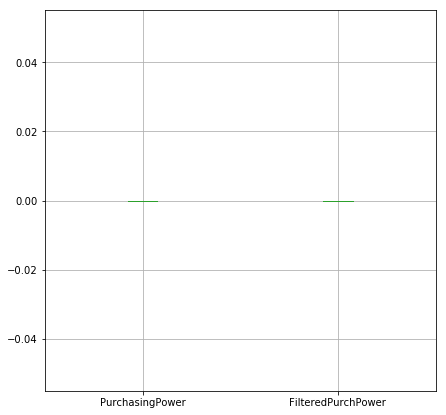

The means of the data before and after filtering are 0.0 and 0.0, respectively


In [142]:
# We can see the effect that large outliers have on purchasing power by 
# comparing their raw and filtered box and whisker plots
mc_df.boxplot(column=['PurchasingPower', 'FilteredPurchPower'], figsize=(7, 7), showfliers=False)
plt.show()
unfiltered_mean = mc_df['PurchasingPower'].mean()
filtered_mean = mc_df['FilteredPurchPower'].mean()

print('The means of the data before and after filtering are {} and {}, respectively'.format(unfiltered_mean, filtered_mean))

In [35]:
#mc_df['Country'].value_counts().index.tolist()
mc_df.loc[:, 'Country']

0                                NaN
1                      United States
2                             Canada
3                      United States
4                             Taiwan
5                             Brazil
6                      United States
7                              India
8                          Australia
9                             Russia
10                            Russia
11                             India
12                            Brazil
13                       Netherlands
14                            Taiwan
15                     United States
16                             Italy
17                    United Kingdom
18                     United States
19                            Brazil
20                     United States
21                     United States
22                     United States
23                    Czech Republic
24                     United States
25                            Russia
26                       Netherlands
2

In the plot above, it is important to note that the fliers have been turned off for the purpose of visualizing the IQR before and after filtering. 

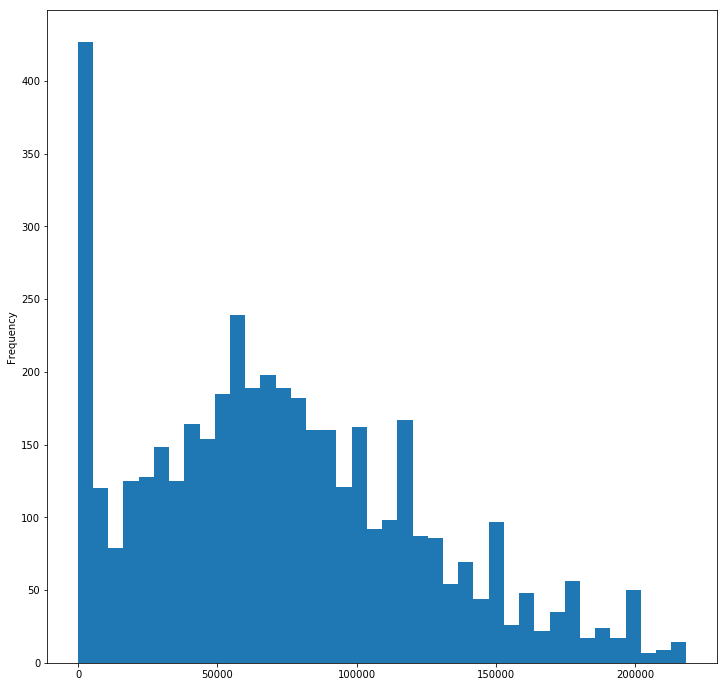

26.1665470208 %


In [41]:
mc_df['FilteredPurchPower'].plot(kind='hist', bins=40, figsize=(12, 12))
plt.show()
print(mc_df['FilteredPurchPower'].count() / mc_df['FilteredPurchPower'].size * 100, '%')

# How does salary vary with demographics?